# Example: Mixing Layer

In [7]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np

## Setup

In [8]:
def randu(nx, ny, nz):
    # returns values between -1 and 1
    return (np.random.rand(nx, ny, nz)-0.5)*2


class MixingLayer(object):
    def __init__(self, resolution, reynolds_number, mach_number, lattice):
        self.resolution = resolution
        self.D = lattice.D
        self.shape = (resolution, resolution, resolution) if (self.D == 3) \
            else (resolution, resolution)
        self._mask = np.zeros(shape=self.shape, dtype=bool)
        self.units = lt.UnitConversion(
            lattice,
            reynolds_number=reynolds_number, mach_number=mach_number,
            characteristic_length_lu=resolution, characteristic_length_pu=1,
            characteristic_velocity_pu=1
        )

    def initial_solution(self, x):
        p = np.array([0 * x[0]], dtype=float)
        nx, ny, *nz = self.shape
        nz = nz[0] if nz else 1
        shearlayerthickness = 0.093
        amplitude = 1
        centering = np.exp(-pow(x[1]/(2*shearlayerthickness), 2)) * amplitude
        u = []
        for dim in range(self.D):
            u.append(randu(nx, ny, nz) * centering)
            u[dim] = u[dim][..., 0] if self.D == 2 else u[dim]
        u[0] = np.tanh(x[1]/(2*shearlayerthickness))
        u = np.array(u, dtype=float)
        return p, u

    @property
    def mask(self):
        return self._mask

    @property
    def grid(self):
        x = np.linspace(-1, 1, num=self.resolution, endpoint=False)
        y = np.linspace(-1, 1, num=self.resolution, endpoint=False)
        z = np.linspace(-1, 1, num=self.resolution, endpoint=False)
        return np.meshgrid(x, y, z, indexing='ij') if self.D == 3 \
            else np.meshgrid(x, y, indexing='ij')

    @property
    def boundaries(self):
        x, y, *z = self.grid
        top = np.zeros(np.shape(y), dtype=bool)
        bottom = np.zeros(np.shape(y), dtype=bool)
        bottom[:, 0] = True  # bottom
        top[:, -1] = True  # top
        downstream = np.array([1.0, 0.0, 0.0]) if self.D == 3\
            else np.array([1.0, 0.0])
        return [
            # moving fluid on top and bottom
            lt.EquilibriumBoundaryPU(top, self.units.lattice, self.units,
                                  downstream),
            lt.EquilibriumBoundaryPU(bottom, self.units.lattice, self.units,
                                  -downstream),
        ]

lattice = lt.Lattice(lt.D2Q9, device = "cpu", use_native=False)
flow = MixingLayer(resolution=256, reynolds_number=10000, mach_number=0.05, 
            lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)
energyspectrum = lt.EnergySpectrum(lattice, flow)
reporter = lt.ObservableReporter(energyspectrum, interval=500, out=None)
simulation.reporters.append(reporter)

steps     time     EnergySpectrum


### Initialized flow

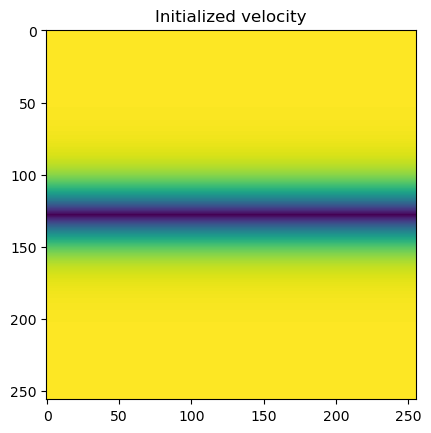

In [9]:
u = lattice.convert_to_numpy(flow.units.convert_velocity_to_pu(lattice.u(simulation.f)))
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm.transpose())
plt.title('Initialized velocity')
plt.show()

## Run simulation

In [11]:
simulation.initialize_pressure()
simulation.initialize_f_neq()
mlups = simulation.step(num_steps=2000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 38.62216318024629


### Velocity
* Velocity field after the simulation

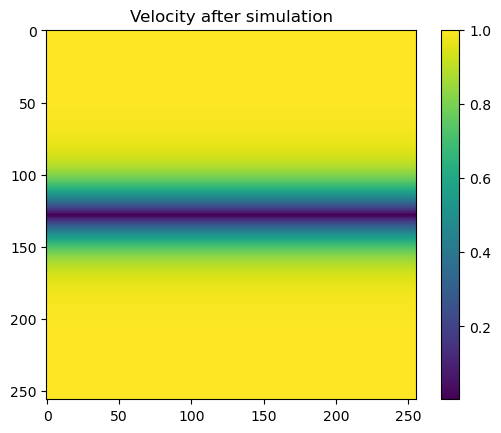

In [14]:
u = lattice.convert_to_numpy(flow.units.convert_velocity_to_pu(lattice.u(simulation.f)))
u_norm = np.linalg.norm(u,axis=0)
plt.imshow(u_norm.transpose())
plt.colorbar()
plt.title('Velocity after simulation')
plt.show()

### Vorticity
* Vorticity field after the simulation

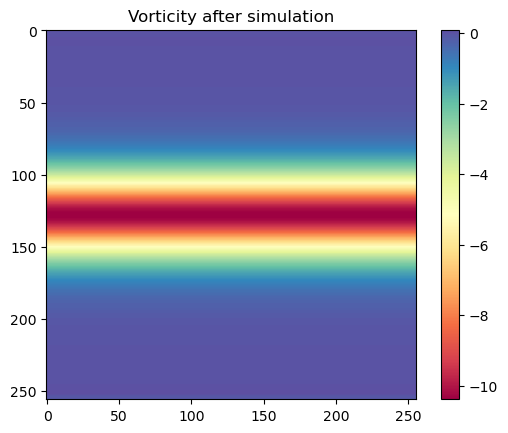

In [16]:
dx = flow.units.convert_length_to_pu(1.0)
grad_u0 = np.gradient(u[0], dx)
grad_u1 = np.gradient(u[1], dx)
vorticity = (grad_u1[0] - grad_u0[1])
plt.imshow(vorticity.transpose(), cmap='Spectral')
plt.colorbar()
plt.title('Vorticity after simulation')
plt.show()